RADI OVDE, instalirala sam NIDN preko pip install, nije ga bilo na conda branch-u

# Introduction to Neural Inverse Design of Nanostructures (NIDN)

Welcome to the notebook describing Neural Inverse Design of Nanostructures (NIDN).

NIDN is a Python package for inverse design of nanostructures using neural networks, powered by [PyTorch](https://pytorch.org/). With NIDN, the user can find configurations of three-dimensional (nano-)structures and metamaterials that match certain desirable properties, for instance the reflection and absorption of light at certain wavelengths. 

For this notebook, we will showcase one example of how NIDN can be used. Together with our Torch-based Rigorous Coupled-Wave Analysis (TRCWA) simulation tool, which is based on the [GRCWA package](https://github.com/weiliangjinca/grcwa) made by Weiliang Jin, we can find a structure that meets our requirements for reflection, transmission, and absorption, e.g., as for the example shown below.

## Important information and core settings in NIDN

You might notice the word `cfg` a lot in the TRCWA code. The config class `cfg` contains all of the parameters the user would need while using TRCWA and makes setting up the inverse design process much more convinient. Feel free to check it out in our [documentation](https://nidn.readthedocs.io/en/latest/). TODO: Link to doc page where all config parameters are explained.

Below are some core details and settings needed for understanding how NIDN works.  

### TRCWA and its layers

TRCWA uses two different kinds of layers; uniform and heterogeneous (patterned). What they have in common is that they are periodic in the two lateral directions and invariant along the vertical direction.

#### Uniform Layers

A uniform layer has the same dielectric constant across the entire layer.

#### Heterogeneous Layers

Heterogeneous (patterned) layers are divided into a grid, where each grid point can have individual dielectric constants.  

### Neural Inverse Design

NIDN is based on a machine learning (ML) approach by [Mildenhall *et al*.](https://link.springer.com/chapter/10.1007/978-3-030-58452-8_24) called NeRF. Both the NeRF network and similar ones, like [sinusoidal representation networks (SIRENs)](https://arxiv.org/pdf/2006.09661.pdf), are available in NIDN. 

#### Our inverse design framework 

The difference between our NeRF-based framework and many other types of inverse design is that the we use backpropagation. In our case, the process is based on an iterative trial-and-error approach where the neural network inputs some initial geometry to the simulation and gets feedback on how far from the desired spectrum it was through error backpropagation.
The focus is only on the task at hand (solving one solution - a specific spectrum/spectra), while for other inverse design frameworks the neural network must often solve the entire solution space of the problem.
The result is that our approach is much more efficient. 

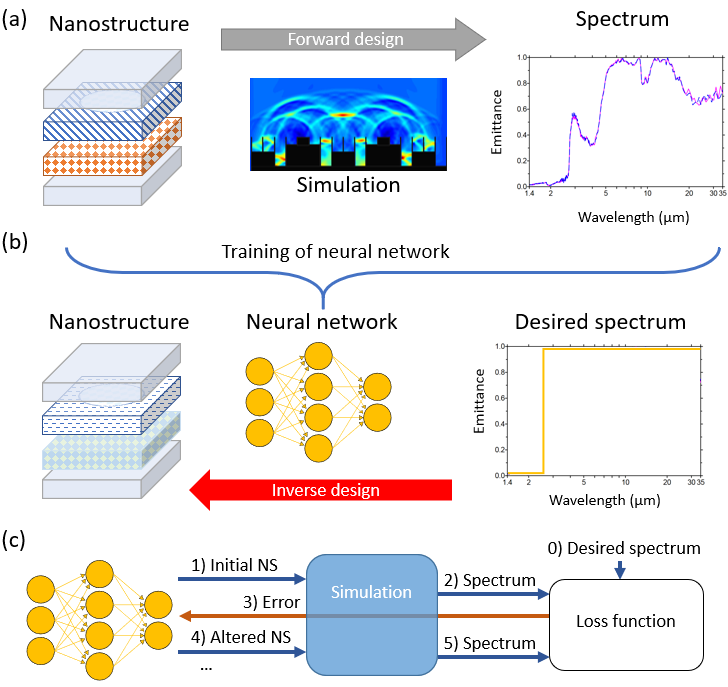

Figure 1: Overview of design processes. (a) Conventional forward design process. (b) Typical inverse design process. Results from (a) are fed into the neural network that subsequently finds the geometry for the desired spectrum. (c) Out NeRF-based inverse design process with backpropagation. The process is based on an iterative trial-and-error approach where the neural network inputs some initial nanostructure (NS) geometry to the simulation and gets feedback on how far from the desired spectrum it was.

#### Direct epsilon estimation (regression)

One approach NIDN takes to get to the desired property of the material is with direct estimation of the dielectric constant - called direct epsilon estimation or regression.
If you want to find, for instance, the dielectric constant for each layer or grid point in a structure such that the reflection, transmission, and absorption (RTA) satisfies your needs, then NIDN can give an estimate of the unrestricted dielectric constant for each frequency.

#### Utilizing real materials (classification)

The drawback with regression is that the dielectric constant for each frequency is not necessarily resembling that of a real material. To make the problem more realistic, NIDN can also classify which material has a dielectric constant for each frequency closest to the estimated one.

A problem with classification is that the selection of real materials can break the differentiability of the network. Currently, torch doesn't allow differentiability of the argmax function.
As a solution, we {Pablo fill in}.

To be able to classify materials, we must have a library of material properties available. For TRCWA, that means knowing the dielectric constant as a function of frequency of the light.
We are in the process of collecting more materials. If you know any good sources of materials over large spectra, feel free to let us know.

## Running NIDN

We are now ready to get started.
Before we go ahead, we must do the imports.

### Imports 

In [1]:
### Imports (TODO remove this when finished)
%load_ext autoreload
%autoreload 2

# Append root folder in case you haven't installed NIDN
import sys
sys.path.append("../")

import nidn
nidn.set_log_level("INFO")

14:11:59|NIDN-INFO| Initialized NIDN for cpu
14:11:59|NIDN-INFO| Using double precision
14:11:59|NIDN-INFO| Switching log level to warning.


# Examples of how to run NIDN 

Now, over to the exciting stuff. In this notebook, we will present three examples. The target spectra in the first and second example have been made using the `Running_TRCWA` notebook, i.e., they serve as ground truths. The structure used is a uniform single-layer made of titanium oxide. 
In Example 1, the epsilon is unrestricted, meaning the dielectric constant can take any value within the upper and lower bounds for epsilon for every frequency point. This is what we call regression.
In Example 2, we redo Example 1 but using classification, where the material closest to the suggested epsilon is chosen. 
In Example 3, we find the structure that satisfies the requirements outlined under Setting the target spectra, basically an optical filter.

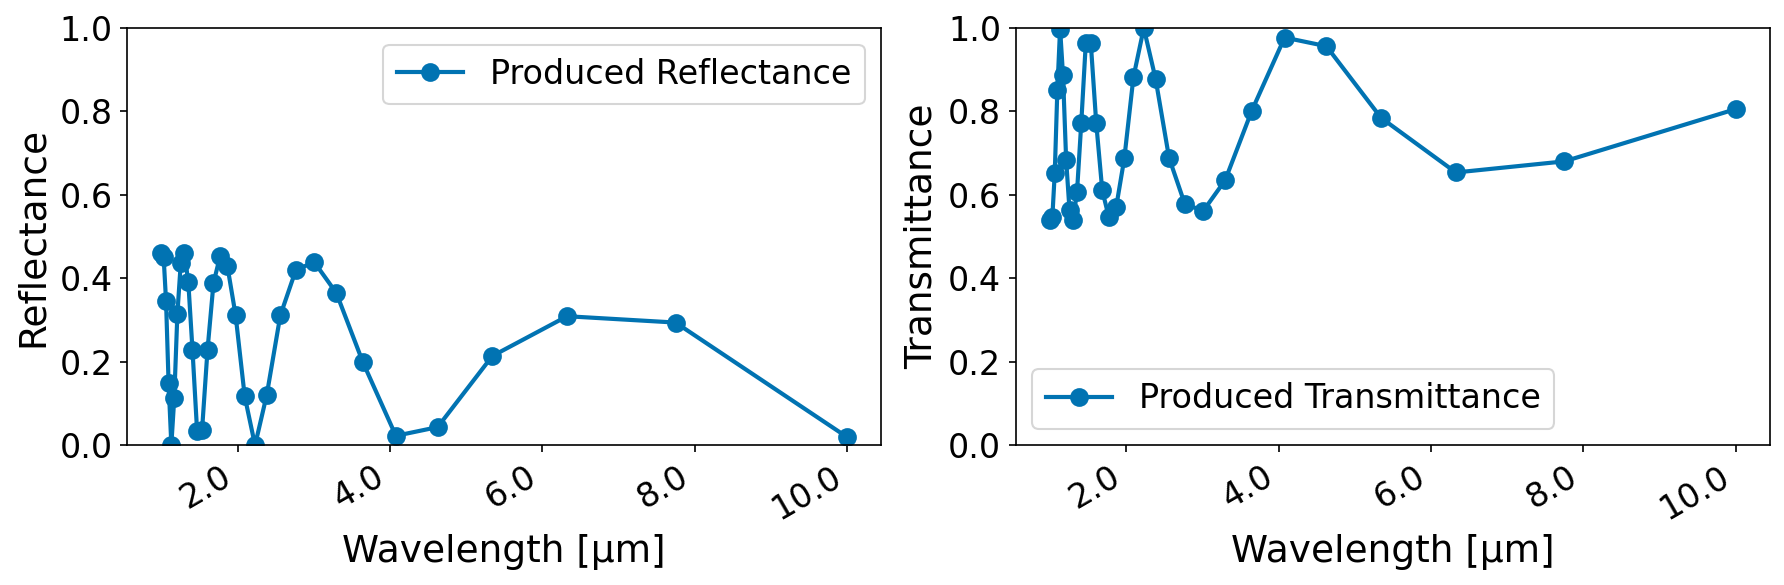

Physical wavelengths are (in meters):
[1.00000000e-05 7.75000000e-06 6.32653061e-06 5.34482759e-06
 4.62686567e-06 4.07894737e-06 3.64705882e-06 3.29787234e-06
 3.00970874e-06 2.76785714e-06 2.56198347e-06 2.38461538e-06
 2.23021583e-06 2.09459459e-06 1.97452229e-06 1.86746988e-06
 1.77142857e-06 1.68478261e-06 1.60621762e-06 1.53465347e-06
 1.46919431e-06 1.40909091e-06 1.35371179e-06 1.30252101e-06
 1.25506073e-06 1.21093750e-06 1.16981132e-06 1.13138686e-06
 1.09540636e-06 1.06164384e-06 1.02990033e-06 1.00000000e-06]


In [2]:
# Load default cfg as starting point
cfg = nidn.load_default_cfg()

# TRCWA Settings
cfg.TRCWA_L_grid = [[0.1,0.0],[0.0,0.1]]
cfg.TRCWA_NG = 11
cfg.PER_LAYER_THICKNESS = [1.0]

# Specify your desired range of wavelengths
cfg.physical_wavelength_range[0] = 1e-6
cfg.physical_wavelength_range[1] = 1e-5
cfg.freq_distribution = "linear"

# Let's investigate 32 frequency points
cfg.N_freq = 32

# Currently, the target spectra is set manually as a list of numbers 
cfg.target_reflectance_spectrum =  [0.01990215,0.18862374,0.29416452,0.31686834,0.30931051,0.27989507,0.21396754,0.12617596,0.04358692,0.00098217,0.02277351,0.09958942,0.19854391,0.29178026,0.36486594,0.41334028,0.43843368,0.44088565,0.42115803,0.37818036,0.31122202,0.22172910,0.12143359,0.03581180,0.00003041,0.03266791,0.11734958,0.21943795,0.31245563,0.38261433,0.42918729,0.45252977,0.45364987,0.43273948,0.38860548,0.31997456,0.22850632,0.12510194,0.03658242,0.00000571,0.03513296,0.12315892,0.22841223,0.32156572,0.39252449,0.43796520,0.46008328,0.45936085,0.43602135,0.38861368,0.31566885,0.21935769,0.11277557,0.02687095,0.00105129,0.05036984,0.14895267,0.25536387,0.34692635,0.41300526,0.45244442,0.46828458,0.46059485,0.42871305,][::2]
cfg.target_transmittance_spectrum = [0.80566155,0.80183012,0.68040095,0.63592999,0.65381371,0.71016360,0.78471449,0.87372850,0.95636285,0.99896277,0.97716848,0.90035231,0.80139917,0.70816446,0.63507985,0.58660559,0.56151111,0.55905677,0.57878055,0.62175262,0.68870337,0.77818657,0.87847102,0.96408236,0.99985706,0.96721862,0.88254093,0.78045866,0.68744676,0.61729215,0.57072126,0.54737868,0.54625622,0.56716181,0.61128826,0.67990851,0.77136297,0.87475156,0.96325655,0.99982487,0.96469840,0.87668054,0.77143817,0.67829456,0.60734302,0.56190626,0.53978890,0.54050873,0.56384214,0.61123979,0.68417021,0.78046270,0.88702387,0.97291039,0.99872179,0.94940799,0.85083899,0.74444367,0.65289492,0.58682550,0.54739120,0.53155152,0.53923725,0.57111012,][::2]
# Since R + T + A = 1, we only need to give the reflectance and transmittance (absorptance is implicit)

nidn.plot_spectrum(cfg,
                   cfg.target_reflectance_spectrum,
                   cfg.target_transmittance_spectrum)

physical_wls, normalized_freqs = nidn.get_frequency_points(cfg)
print("Physical wavelengths are (in meters):")
print(physical_wls)

NB: The frequency range is not stable when we change all the time!

What happened in the cell above is that we choose 32 frequency points {logarithmically/linearly} spread between 0.1 and 4 in the frequency domain. In TRCWA, the frequencies are given in relation to the lattice vectors, given in micrometers. A frequency of 0.1 and 4 therefore corresponds to a physical wavelength of (1/0.1) μm = 10 μm and (1/1) μm = 1.0 μm, respectively, as given by nidn.get_frequency_points() function.

If you want to make sure the design target is obtainable, for instance to use it as a ground truth, then you can do a simulation of the spectrum from some structure using the `Running_TRCWA` notebook.

## Example 1 - Uniform single-layer with unrestricted epsilon

Let's start with a uniform single-layer and see if NIDN can get sufficiently close to the ground truth.

In [3]:
cfg.Nx = 1 # Set layer size  to 1x1 (interpreted as uniform)
cfg.Ny = 1
cfg.N_layers = 1 # Choose number of layers

# Allowed range of epsilon values
cfg.real_min_eps = 0.0
cfg.real_max_eps = 20.0
cfg.imag_min_eps = 0.0
cfg.imag_max_eps = 3.0

cfg.type = "regression" # Choose type as described above
cfg.iterations = 200 # Set number of training iterations (that is forward model evaluations) to perform

In [4]:
#Show all used settings
nidn.print_cfg(cfg)

name                   : example_name   |use_gpu                : 0              |seed                   : 100            |
model_type             : siren          |iterations             : 200            |learning_rate          : 8e-05          |
type                   : regression     |reg_loss_weight        : 0.05           |use_regularization_loss: 1              |
L                      : 1.0            |absorption_loss        : 0              |n_neurons              : 100            |
hidden_layers          : 9              |encoding_dim           : 4              |siren_omega            : 1.0            |
add_noise              : 0              |noise_scale            : 0.001          |eps_oversampling       : 1              |
real_min_eps           : 0.0            |real_max_eps           : 20.0           |imag_min_eps           : 0.0            |
imag_max_eps           : 3.0            |solver                 : TRCWA          |Nx                     : 1              |
Ny      

`print_cfg(cfg)` shows you more or less everything you want to know about the config.
Using `run_training(cfg)`, we run the network until it reaches the number of iterations set above (or until you interrupt it).

In [5]:
nidn.run_training(cfg);

/home/t/miniconda3/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343967769/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
14:13:05|NIDN-INFO| ###  New Best=0.3652 with SpectrumLoss=0.3652 ### L1=0.3652
14:13:05|NIDN-INFO| It=0     Loss=0.3652   |  weighted_avg=0.3652  |  SpectrumLoss=0.3652 | L1=0.3652
14:13:05|NIDN-INFO| ###  New Best=0.3502 with SpectrumLoss=0.3502 ### L1=0.3502
14:13:05|NIDN-INFO| ###  New Best=0.3398 with SpectrumLoss=0.3398 ### L1=0.3398
14:13:05|NIDN-INFO| ###  New Best=0.3306 with SpectrumLoss=0.3306 ### L1=0.3306
14:13:05|NIDN-INFO| ###  New Best=0.3158 with SpectrumLoss=0.3158 ### L1=0.3158
14:13:05|NIDN-INFO| ###  New Best=0.2999 with SpectrumLoss=0.2999 ### L1=0.2999
14:13:05|NIDN-INFO| It=5     Loss=0.2999   |  weighte

### Interpretation of results

#### Loss plot

The loss as a function of model evaluations is presented below. As the training evolves, the three losses here, [L1](https://afteracademy.com/blog/what-are-l1-and-l2-loss-functions), Loss, and Weighted Average Loss, can be seen to decrease. {Pablo add link/explanation to the other losses}.

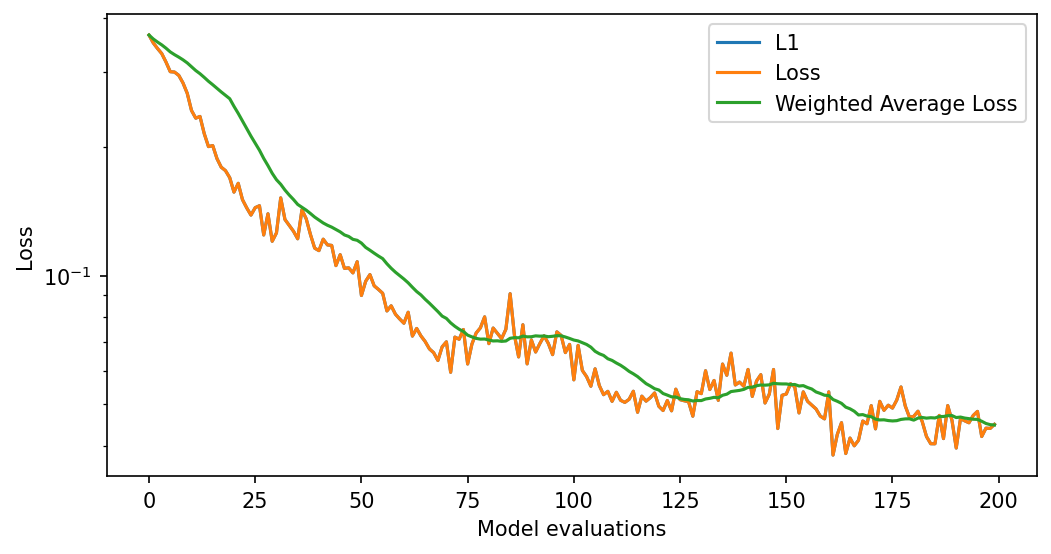

In [6]:
nidn.plot_losses(cfg)

#### Spectrum plots

The produced RTA spectra are plotted together with the target spectra in the figure below.

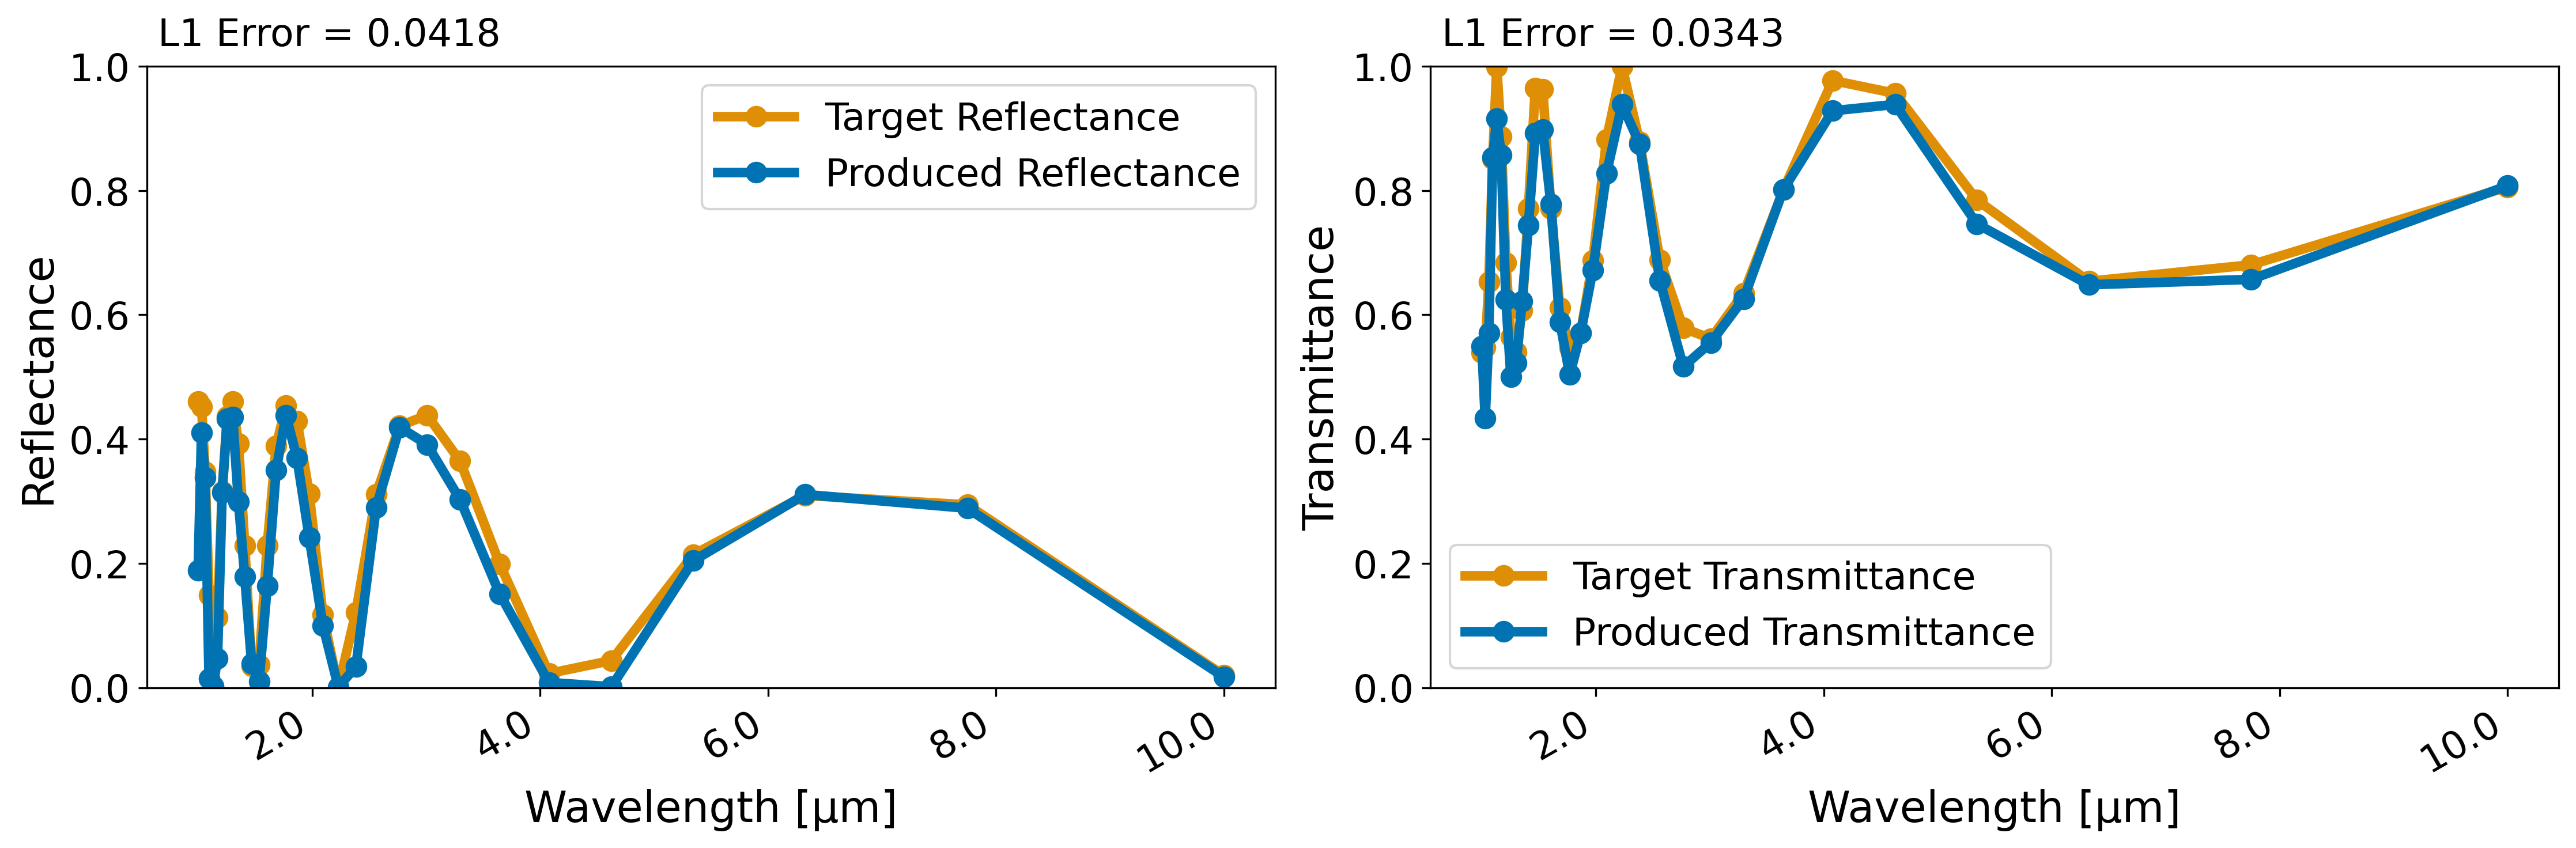

In [7]:
nidn.plot_spectra(cfg)

#### Absolute grid values plot

The complex absolute value of the epsilon over all frequencies is presented here. This plot is in general more useful for patterned multilayers.

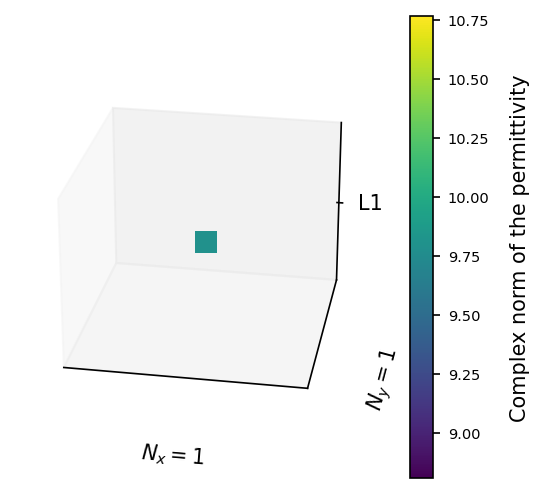

In [8]:
nidn.plot_model_grid(cfg)

#### Epsilon vs frequency and real materials

The following function plots the epsilon values vs. frequency of grid points against real materials in our library. This plot is in general more useful for patterned multilayers.

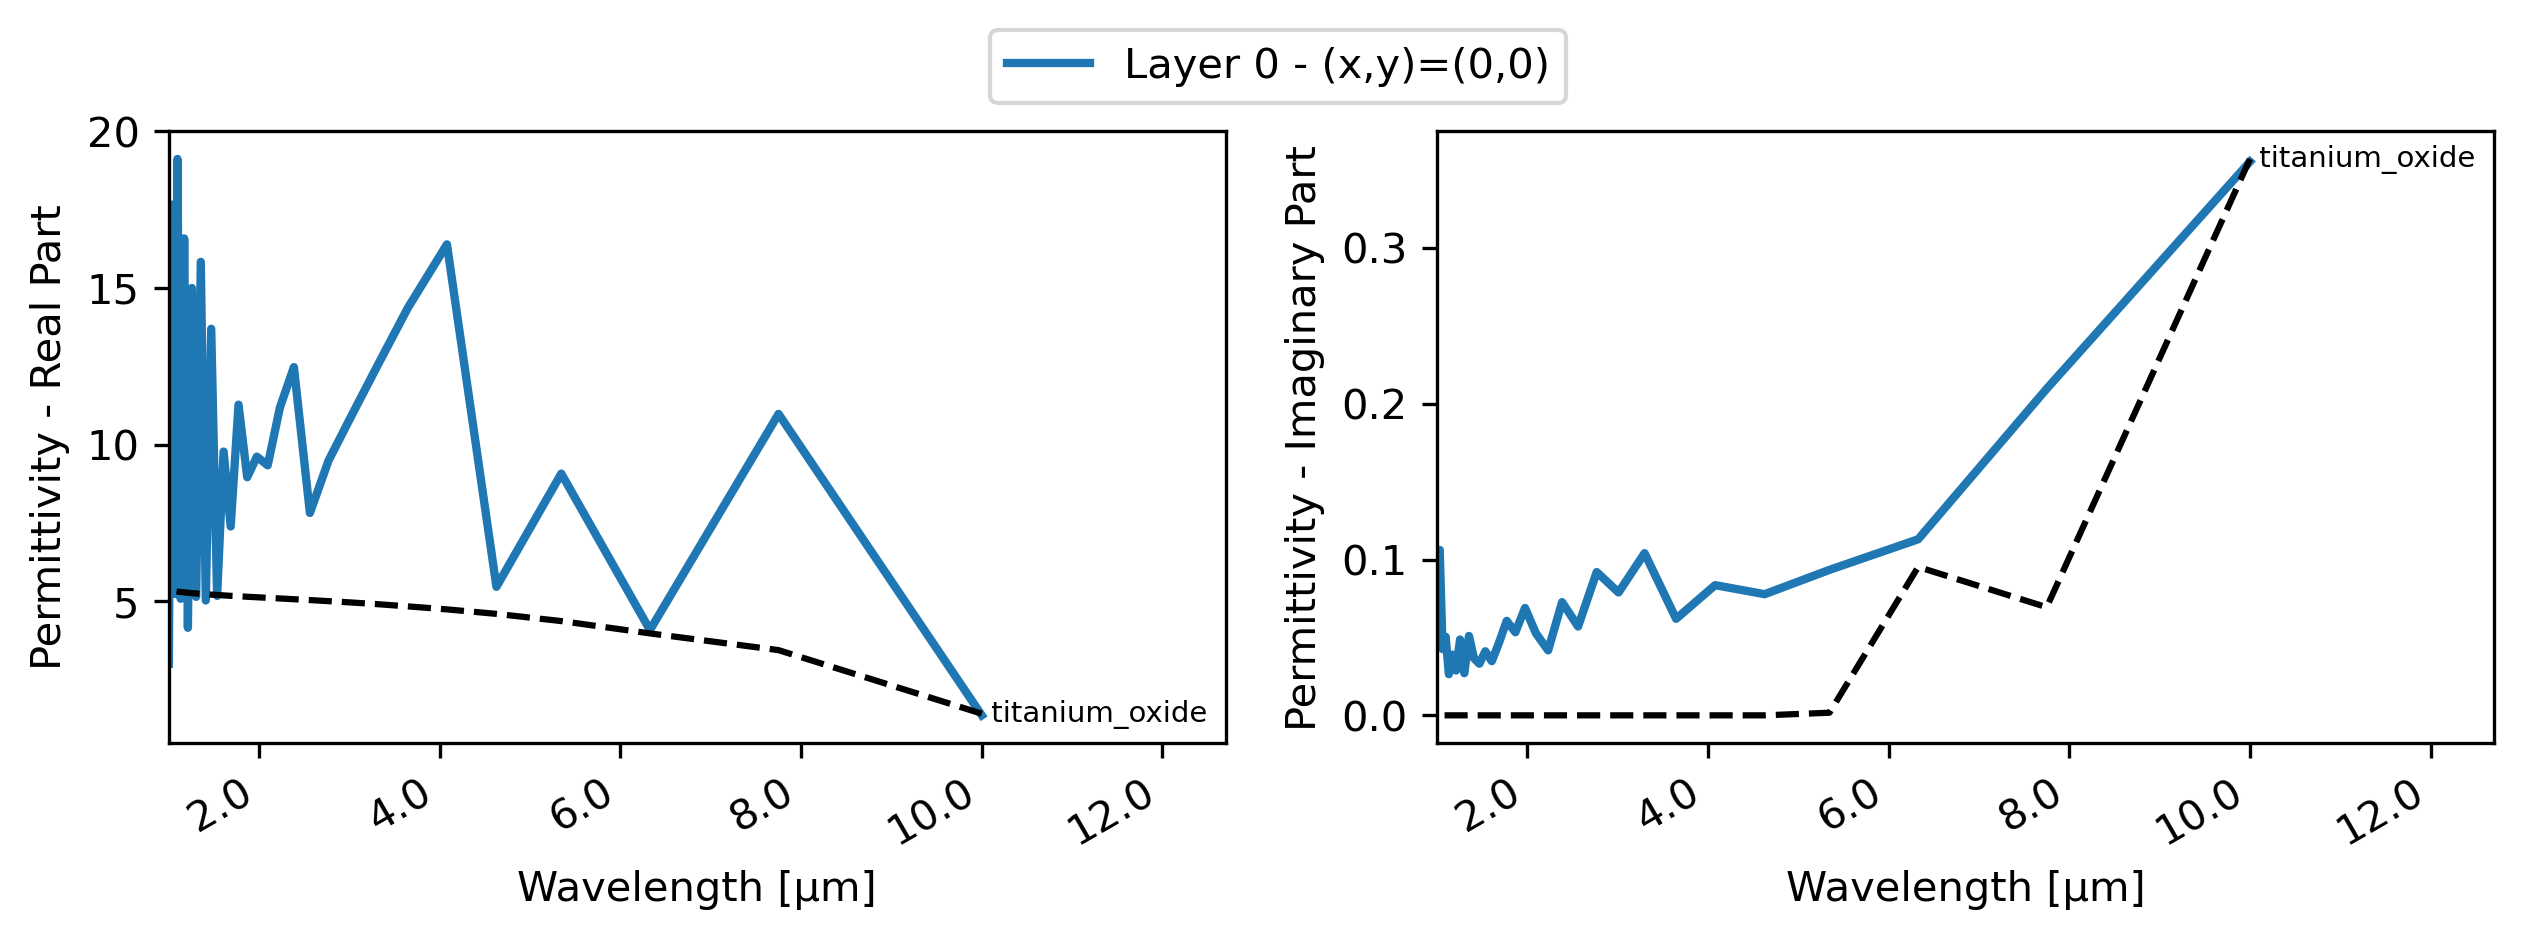

In [9]:
nidn.plot_eps_per_point(cfg,compare_to_material="titanium_oxide")

## Example 2 - Uniform single-layer with materials classification

Next up is the same example, a uniform single-layer of titanium oxide, but this time we check if NIDN can predict the correct material.

In [ ]:
cfg.pop("model",None); # Forget the old model
cfg.Nx = 1 # Set layer size  to 1x1 (interpreted as uniform)
cfg.Ny = 1
cfg.N_layers = 1 # Choose number of layers

cfg.type = "classification" # Choose type as described above
cfg.iterations = 100 # Set number of training iterations (that is forward model evaluations) to perform

In [ ]:
nidn.run_training(cfg);

In [ ]:
nidn.plot_losses(cfg)
nidn.plot_spectra(cfg)
nidn.plot_model_grid(cfg)
nidn.plot_eps_per_point(cfg,compare_to_material="titanium_oxide")

As can be seen from the plots, the prediction is correct and the loss is even lower.

## Example 3 - Optical filter with regression

The goal of using NIDN is to find a structure with reflection, transmission, and reflection spectra as close to you target spectra as possible. We might for instance want a filter that has a high transmission for wavelengths around 1550 nm and low transmission for other wavelengths. The reflection should be opposite to that of the transmission and the absorption should be minimal for all wavelengths.
The target spectra with these requirements can be set using the following code:

For the third and final example, we will try to find a structure that satisfies these requirements setting the target spectra using regression. The structure would work as an optical filter with transmission only for wavelengths around 1550 nm.
The structure consists of Y layers with X x X grid points per layer. As can be seen in the code below, we make use of oversampling.

In [ ]:
# Define target for the filter
cfg = nidn.load_default_cfg()
cfg.N_freq = 20
cfg.target_reflectance_spectrum =   12*[1.0] + [0.0] + 7*[1.0]
cfg.target_transmittance_spectrum = 12*[0.0] + [1.0] + 7*[0.0]
cfg.physical_wavelength_range[0] = 1e-6
cfg.physical_wavelength_range[1] = 1e-5
cfg.freq_distribution = "linear"


nidn.plot_spectrum(cfg,
                   cfg.target_reflectance_spectrum,
                   cfg.target_transmittance_spectrum)

In [ ]:
# Allowed range of epsilon values
cfg.pop("model",None); # Forget the old model
cfg.real_min_eps = 0.0
cfg.real_max_eps = 20.0
imag_min_eps = 0.0
imag_max_eps = 3.0

cfg.Nx = 1 # Set layer size  to 16x16 (each of the grid points has its own epsilon now)
cfg.Ny = 1
cfg.eps_oversampling = 1
cfg.N_layers = 3 # Less layer to keep compute managable
cfg.type = "regression" # Choose type as described above (for now still regression)
cfg.iterations = 400 # Set number of training iterations (that is forward model evaluations) to perform

In [ ]:
nidn.print_cfg(cfg)

In [ ]:
nidn.run_training(cfg);

In [ ]:
# The other plots
nidn.plot_losses(cfg)
nidn.plot_spectra(cfg)
nidn.plot_model_grid(cfg)
nidn.plot_eps_per_point(cfg,legend=False)

NIDN is able to get quite close to the desired spectra with the unrestricted epsilon. 

#### Material ID plot

Finally, we will present another plot, showing the real materials closest to the unrestricted ones for each grid point.
The layers are numbered from bottom to top, and the light is incident on the first layer, i.e., the bottom of the stack.

In [ ]:
nidn.plot_material_grid(cfg)

NB Here we should have plotted the RTA result of this structure.
In case you want to save results you can use this handy function to save it to the results folder with a current timestamp.

In [ ]:
nidn.save_run(cfg)

# You can save all available plots to a single folder using this function
nidn.save_all_plots(cfg,save_path="../results/example/")